# Meta Inc. Stock price predictions

Let's take a look to stock prices and market capitalisation as a result of how market reacts to financial statistics of the company. 
First of all we need to extract financial statistics from the web. After that we need to determine affection of this statistics to stock price and discover correlation.
Final step will be building model to predict market capitalisation for the next quorter.

Import libraries

In [1]:
import pandas as pd
!mamba install bs4==4.10.0 -y
!mamba install html5lib==1.1 -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.7.6) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['bs4==4.10.0']

pkgs/main/noarch         [=>                  ] (--:--) No change
pkgs/main/noarch 

In [90]:
#Import libraries for webscrapping
import requests
from bs4 import BeautifulSoup

Set url and get request

In [91]:
url = "https://www.macrotrends.net/stocks/charts/META/meta-platforms/revenue"

html_data = requests.get(url).text   #get data from the webpage
souped_html = BeautifulSoup(html_data, 'html5lib') #Use beautifulsoup
souped_html.title

<title>Meta Platforms Revenue 2010-2022 | META | MacroTrends</title>

In [92]:
# Find the second table with Quarterly Revenue /or use 0 for first table
revenue_table = souped_html.find_all('table')[1]   

#Create blank dataframe 
revenue_dataframe = pd.DataFrame(columns=["Date", "Revenue"]) 
 
# Find all tr tags and put data into Dataframe
count_of_missed_rows = 0
for row in revenue_table.find("tbody").find_all("tr"):  

    col = row.find_all("td") 
    date = col[0].text 
    Revenue = col[1].text
    Revenue = Revenue.replace('$', '').replace(',', '')

    if Revenue.isdigit():
        Revenue = float(Revenue)
        revenue_dataframe = revenue_dataframe.append({"Date":date, "Revenue":Revenue}, ignore_index=True)
    else: 
        count_of_missed_rows = count_of_missed_rows + 1
        
print("Missed rows:", count_of_missed_rows) #How many rows were missed

Missed rows: 1


In [93]:
revenue_dataframe.head()

,Date,Revenue
0,2022-06-30,28822.0
1,2022-03-31,27908.0
2,2021-12-31,33671.0
3,2021-09-30,29010.0
4,2021-06-30,29077.0


In [94]:
revenue_dataframe.tail()

,Date,Revenue
45,2011-03-31,731.0
46,2010-12-31,731.0
47,2010-09-30,467.0
48,2010-06-30,431.0
49,2010-03-31,345.0


In [95]:
revenue_dataframe.dtypes

Date        object
Revenue    float64
dtype: object

Now when revenue data extracted we need stocks price data.

## Extracting stock prices

I'm going to use Yahoo finance API to extract stock prices history.

In [96]:
# Import library
import yfinance as yf

In [97]:
# Set ticker
meta = yf.Ticker("META")

In [98]:
# Get history data
hist = meta.history(period="max")

In [99]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400,0,0
2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700,0,0
2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600,0,0
2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000,0,0
2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200,0,0


Let's visualise data

<AxesSubplot:xlabel='Date'>

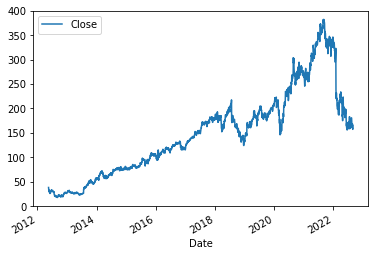

In [100]:
# Reset index
hist.reset_index(inplace=True)
# Plot the chart
hist.plot(x="Date", y="Close")

In [101]:
def join_price_and_revenue_dfs(price_df, revenue_df, shift=0):
    # Returns new dataframe after comparison of the dates. 

    # Import required libraries
    from datetime import datetime
    from datetime import timedelta
    
    # Set last day var to determine since what day stock prices is availiable
    last_history_date = hist.iloc[0,0]
    # Set time delta
    timedelta_object = timedelta(days=1)
    # Create blank dataframe to save result
    result_df = pd.DataFrame(columns=['date', 'revenue', 'price'])
    
    # Loop trought Revenue dataframe. 
    for index, row in revenue_df.iterrows():
        
        # Get date of the report. Then to exclude affection of the reports to the data
        # I'll use dates two days, three days and for days before the report.
        revenue_date = datetime.strptime(revenue_df.iloc[index, 0], "%Y-%m-%d")
        two_days_before_revenue_date = revenue_date - timedelta_object * 2
        three_days_before_revenue_date = revenue_date - timedelta_object * 3
        four_days_before_revenue_date = revenue_date - timedelta_object * 4
        
        # Check for revenue report days before IPO
        if revenue_date < last_history_date:
            break
            
        # Search for report date in second dataframe 
        i=0
        for price_index, price_row in price_df.iterrows():
            # Get date from second dataframe
            price_date = price_df.iloc[price_index, 0]
            
            # If date(four days before report) found in prices DF then set 'price' var etc... 
            if price_date == four_days_before_revenue_date:
                price = price_df.iloc[price_index - 2, 4]
                i=1
            if price_date == three_days_before_revenue_date:
                price = price_df.iloc[price_index - 1, 4]
                i=2               
            if price_date == two_days_before_revenue_date:
                price = price_df.iloc[price_index, 4]
                i=3
            else:
                 continue  
        # Built result dataframe            
        result_df = result_df.append({"date":revenue_date, "revenue":revenue_df.iloc[index, 1], "price":price}, ignore_index=True)
    return result_df

In [102]:
price_rev_df = join_price_and_revenue_dfs(hist, revenue_dataframe)

The theory is that after the report date we should wait aproximately 3 month to see  how this report affected to the market price. So current report data will be used for predictions to the next 3 month.
For this purposes we need shif price column down to 1 row.

In [103]:
# Clone dataframe
price_rev_df_shifted = price_rev_df 
# Shift price column
price_rev_df_shifted['price'] = price_rev_df_shifted['price'].shift(1)

In [104]:
price_rev_df_shifted.head()

,date,revenue,price
0,2022-06-30,28822.0,NaN
1,2022-03-31,27908.0,160.679993
2,2021-12-31,33671.0,229.860001
3,2021-09-30,29010.0,342.940002
4,2021-06-30,29077.0,340.649994


Now we can visualise the data using scatterplot

<AxesSubplot:xlabel='revenue', ylabel='price'>

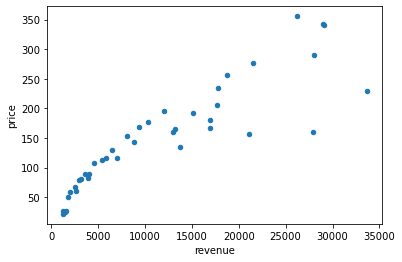

In [105]:
price_rev_df_shifted.plot(x='revenue', y='price', kind="scatter")

As we can see linear regression models can be used to predict future price.

## Linear model prediction

Since we have dataframe and know that there is linear correlation between <b>price</b> and <b>revenue</b> we can build linear regression model. Let's jump right in.

In [106]:
# Import libraries
import numpy as np
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Linear model algorithm
from sklearn import linear_model

Cut of first row with NaN and date column.

In [131]:
price_rev_df_shifted_without_first_row = price_rev_df_shifted[['revenue','price']][1:len(price_rev_df_shifted)]
price_rev_df_shifted_without_first_row.head()

,revenue,price
1,27908.0,160.679993
2,33671.0,229.860001
3,29010.0,342.940002
4,29077.0,340.649994
5,26171.0,355.640015


In [142]:
price_rev_first_row = price_rev_df_shifted[['revenue','price']][0:1]
price_rev_first_row

,revenue,price
0,28822.0,NaN


Create train and test dataset

In [132]:
# Check for data types
price_rev_df_shifted_without_first_row.dtypes

revenue    float64
price      float64
dtype: object

In [134]:
# Split test and train data
msk = np.random.rand(len(price_rev_df_shifted_without_first_row)) < 0.8
train = price_rev_df_shifted_without_first_row[msk]
test = price_rev_df_shifted_without_first_row[~msk]

When dataframe splited build the model

In [138]:
# Built the model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['revenue']])
y = np.asanyarray(train[['price']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.00872973]]


In [139]:
y_hat= regr.predict(test[['revenue']])
x = np.asanyarray(test[['revenue']])
y = np.asanyarray(test[['price']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 3872.44
Variance score: 0.63


In [143]:
y_hat= regr.predict(price_rev_first_row[['revenue']])

In [147]:
print("Predicted price: ",y_hat[0,0])

Predicted price:  300.4587480929705
